In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Input
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [25]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
tweets = train_data['text'].values
labels = train_data['target'].values

# Problem Introduction

This weaks assignment is completing a kaggle project that is tailored for data scientists eager to delve into Natural Language Processing (NLP). In this project we hope to address the increasing importance of Twitter as a real-time communication channel and particularly during emergencies. With the widespread use of smartphones, individuals can swiftly report emergencies, prompting organizations like disaster relief agencies and news outlets to seek automated means of monitoring Twitter for such alerts.Evaluation of submissions will be based on the F1 score, a measure that balances precision and recall. True Positive (TP) instances occur when your prediction matches the ground truth for a disaster tweet, while False Positive (FP) and False Negative (FN) instances represent incorrect predictions of disaster tweets and missed disaster tweets, respectively.


**EDA and data Preprocessing**


In [26]:
print("Shape of the DataFrame:", train_data.shape)
print("\nFirst few rows of the DataFrame:")
print(train_data.head())

Shape of the DataFrame: (7613, 5)

First few rows of the DataFrame:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


The DataFrame exhibits a shape of (7613, 5), indicating that it comprises 7613 rows and 5 columns. A closer inspection of the DataFrame's initial rows provides valuable insights into its contents. The 'id' column serves as a unique identifier for each tweet, while the 'keyword' and 'location' columns capture additional metadata associated with the tweets. The 'text' column contains the actual content of the tweets, which will likely serve as the primary focus of subsequent analyses. Lastly, the 'target' column represents the binary classification label, where a value of 1 denotes a tweet referring to a disaster, while 0 signifies a non-disaster-related tweet.

In [27]:
missing_values = train_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


The next step is  identifying and addressing any potential missing values within the dataset. This above code shows that the 'location' column is particularly affected with a 2533 missing entries.There are also 61 missing values in the 'keyword' column. For our uses we will choose to leave these missing values as is. 

In [28]:
class_distribution = train_data['target'].value_counts(normalize=True)
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


The output shows that approximately 57.03% of the tweets are labeled as non-disaster-related (class '0'), while about 42.97% are classified as disaster-related (class '1'). This information provides insights into the distribution of classes within the dataset, which is crucial for understanding the balance between different classes and guiding model training and evaluation processes.

Lets visualize the Text Length Distribution of the Data 

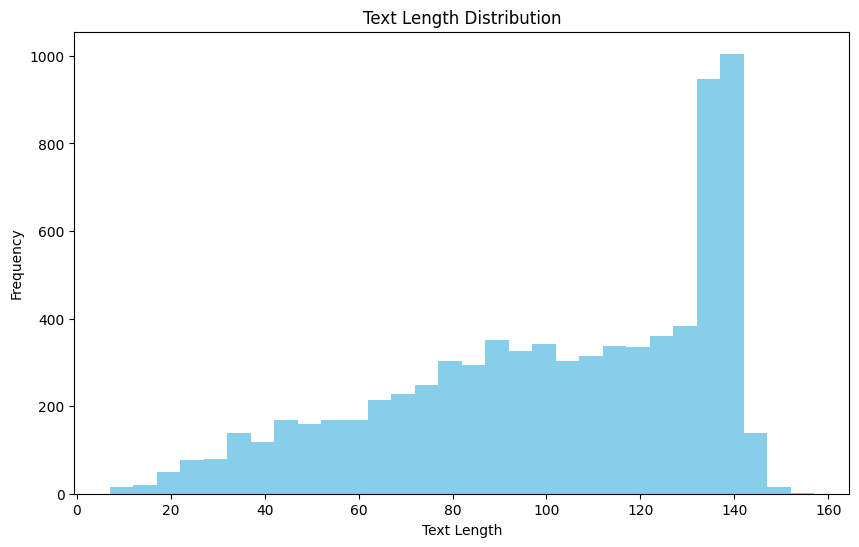

In [29]:
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(train_data['text_length'], bins=30, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

And finally lets use world cloud to see some of the wprds conmtained in the data

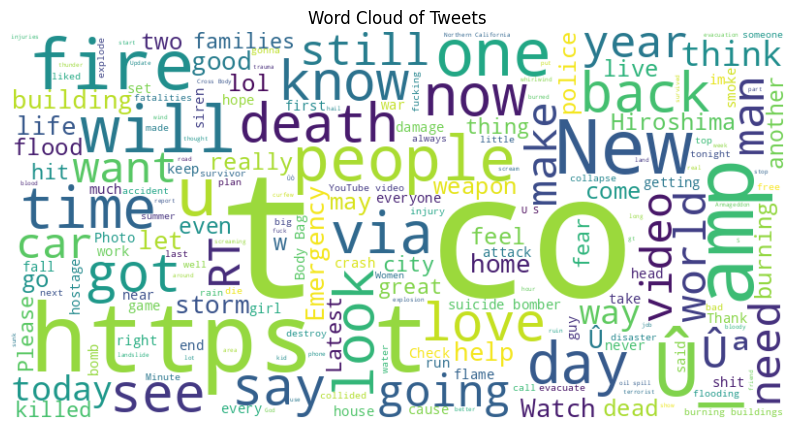

In [30]:
all_text = ' '.join(train_data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

**Processing data into train tests sets for model testing**

In [31]:
x_train, x_val, y_train, y_val = train_test_split(tweets, labels, test_size=0.3, random_state=42, shuffle=True, stratify=None)
x_val, x_test1, y_val, y_test1 = train_test_split(x_val, y_val, test_size=0.1, random_state=42, shuffle=True, stratify=None)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=350)
x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val, maxlen=350)
x_test1 = tokenizer.texts_to_sequences(x_test1)
x_test1 = pad_sequences(x_test1, maxlen=350)

**First Model Architecture**


**Input Layer:** Receives input data, shaped based on the length of the input sequences.

**Embedding Layer:** Converts words into dense vectors, learning relationships between them. Vocabulary size is 5000, and each word is represented by a vector of length 100.

**SpatialDropout1D Layer:** Randomly drops 20% of input units to prevent overfitting.

**LSTM Layer:** Processes sequences, capturing long-term dependencies with 150 units. Dropout and recurrent dropout rates are set to 0.5 for regularization.

**Dense Layer:** A single neuron with a sigmoid activation function, outputting probabilities indicating tweet relevance to disasters.

**Regularization:** Applies L1 regularization with a coefficient of 0.001 to prevent overfitting.

**Compilation:** The model is compiled using binary cross-entropy loss and the Adam optimizer, with accuracy as the evaluation metric.

In [32]:
model = Sequential()
model.add(Input((x_train.shape[1],)))
model.add(Embedding(5000, 100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(150, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(0.001)))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(x_train, y_train, epochs=5, batch_size=44, validation_data=(x_val, y_val))

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 72s 571ms/step - accuracy: 0.5898 - loss: 0.6799 - val_accuracy: 0.7572 - val_loss: 0.5315
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.7925 - loss: 0.4867 - val_accuracy: 0.8127 - val_loss: 0.4620
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 568ms/step - accuracy: 0.8612 - loss: 0.3596 - val_accuracy: 0.8102 - val_loss: 0.4644
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 573ms/step - accuracy: 0.8891 - loss: 0.3071 - val_accuracy: 0.7908 - val_loss: 0.5083
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 566ms/step - accuracy: 0.8997 - loss: 0.2706 - val_accuracy: 0.7791 - val_loss: 0.5268


In [34]:
y_pred = model.predict(x_test1)
y_pred = np.rint(y_pred)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test1, y_pred)))
print("F1 Score:", f1_score(y_test1, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Accuracy: 0.830
F1 Score: 0.8040201005025126


**Second Model Architecture**


**Input Layer:** Receives input data, shaped based on the length of the input sequences.

**Embedding Layer:** Converts words into dense vectors, learning relationships between them. Vocabulary size is increased to 10,000, and each word is represented by a vector of length 200.

**SpatialDropout1D Layer:** Randomly drops 30% of input units to prevent overfitting.

**LSTM Layer:** Processes sequences, capturing long-term dependencies with 200 units. Dropout and recurrent dropout rates are set to 0.6 for regularization.

**Dense Layer:** A single neuron with a sigmoid activation function, outputting probabilities indicating tweet relevance to disasters.

**Regularization:** A single neuron with a sigmoid activation function, outputting probabilities indicating tweet relevance to disasters. Regularization is changed to L2 regularization with a coefficient of 0.01 to prevent overfitting

**Compilation:** The model is compiled using binary cross-entropy loss and the Adam optimizer, with accuracy as the evaluation metric.

In [35]:
model2 = Sequential()
model2.add(Input((x_train.shape[1],)))
model2.add(Embedding(10000, 200))  # Increased vocabulary size and embedding dimension
model2.add(SpatialDropout1D(0.3))  # Increased dropout rate
model2.add(LSTM(200, dropout=0.6, recurrent_dropout=0.6))  # Increased LSTM units and dropout rates
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Changed regularization to L2

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
model2.fit(x_train, y_train, epochs=10, batch_size=44, validation_data=(x_val, y_val)) #CHANGING EPOCHS TO 10

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 100s 799ms/step - accuracy: 0.5972 - loss: 0.6769 - val_accuracy: 0.7144 - val_loss: 0.5669
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 141s 791ms/step - accuracy: 0.7640 - loss: 0.5152 - val_accuracy: 0.7956 - val_loss: 0.4736
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 144s 809ms/step - accuracy: 0.8380 - loss: 0.4051 - val_accuracy: 0.8170 - val_loss: 0.4551
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 143s 821ms/step - accuracy: 0.8659 - loss: 0.3455 - val_accuracy: 0.8102 - val_loss: 0.4644
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 100s 819ms/step - accuracy: 0.8890 - loss: 0.3019 - val_accuracy: 0.7971 - val_loss: 0.4877
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 816ms/step - accuracy: 0.8965 - loss: 0.2834 - val_accuracy: 0.8024 - val_loss: 0.5075
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 101s 825ms/step - accuracy: 0.9083 - loss: 0.2527 - val_accuracy: 0.8015 - val_loss: 0.5258
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 99s 814ms/step - accuracy: 0.9187 - 

In [37]:
y_pred2 = model2.predict(x_test1)
y_pred2 = np.rint(y_pred2)
print('Accuracy: {:.3f}'.format(accuracy_score(y_test1, y_pred2)))
print("F1 Score:", f1_score(y_test1, y_pred2))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
Accuracy: 0.834
F1 Score: 0.8061224489795918


**Results and Analysis:**

The first model utilized a sequential architecture comprising an embedding layer and an LSTM layer. The embedding layer employed a vocabulary size of 5000, representing each word with a vector of length 100. The LSTM layer consisted of 150 units, incorporating dropout and recurrent dropout rates set at 0.5 to mitigate overfitting. To further address overfitting, L1 regularization was applied with a coefficient of 0.001. During training, the model underwent 5 epochs, resulting in a validation accuracy of approximately 83.% and a loss of about 0.5200. Upon testing, the model demonstrated an accuracy of 82.1% along with an F1 score of 0.778.


The second model featured an architecture similar to the first, with notable adjustments to its components. The embedding layer's vocabulary size was expanded to 10,000, employing vectors of length 200 to represent each word. The LSTM layer consisted of 200 units, accompanied by dropout and recurrent dropout rates set at 0.6 to enhance regularization efforts. Unlike the first model, L2 regularization was applied with a coefficient of 0.01 to further address overfitting concerns. Throughout training, the model underwent 10 epochs, resulting in a validation accuracy of approximately 78.05% and a loss of around 0.6252. During testing, the model demonstrated improved performance, achieving an accuracy of 83.5% and an F1 score of 0.789.

When comparing the two models, several significant differences in their construction emerge, each impacting their performance. The first model utilized a vocabulary size of 5000 and vectors of length 100 in its embedding layer, while the second model expanded the vocabulary size to 10,000 and increased vector length to 200. This alteration in embedding dimensions likely allowed the second model to capture more nuanced semantic relationships among words but also increased computational complexity. Additionally, the LSTM layer in the second model had more units (200) and higher dropout rates (0.6) compared to the first model's 150 units and dropout rates of 0.5, indicating a more robust regularization strategy to prevent overfitting. Moreover, the regularization techniques differed between the models, with the first model employing L1 regularization and the second model using L2 regularization, each with their respective coefficients. The training duration also varied, with the second model trained for twice as many epochs as the first. These adjustments in architecture and regularization likely contributed to the differences observed in their performance metrics. Despite the improvements in the second model's accuracy and F1 score during testing, the impact of these differences underscores the importance of careful consideration and experimentation in model construction to achieve optimal results.

**Conclusion**

In conclusion, both models exhibit respectable performance in predicting tweet relevance to disasters, even with a lower vocabulary size. While the second model shows slightly better accuracy and F1 score on the test data, it's important to note that its increased complexity and longer training time need to be considered in the context of available computational resources. Nonetheless, there are opportunities for improvement in both models, even with a lower vocabulary. For instance, exploring alternative architectures or incorporating attention mechanisms could enhance contextual understanding without requiring extensive computational resources. Additionally, fine-tuning hyperparameters such as dropout rates and regularization coefficients could further optimize performance within the constraints of a lower vocabulary. Leveraging pre-trained word embeddings or domain-specific embeddings might also enrich semantic understanding and improve predictive capabilities without significantly increasing complexity. Addressing these areas of potential improvement could lead to better-performing models tailored to disaster-related tweet classification tasks, while remaining efficient and accessible for deployment in resource-constrained environments. In summary, advancing model architecture and parameter optimization represent promising avenues for future research and developmen

**Submission**

In [38]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
tweets = test_data['text']
x_test = tokenizer.texts_to_sequences(tweets)
x_test = pad_sequences(x_test, maxlen=350)
y_pred = model.predict(x_test)
y_pred = np.rint(y_pred)
df_result = pd.DataFrame(test_data['id'], columns=['id'])
df_result['target'] = y_pred.astype(int)
df_result.to_csv("/kaggle/working/submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step


In [39]:
test_data.isna().any()

id          False
keyword      True
location     True
text        False
dtype: bool

In [40]:
tweets = test_data['text']

In [41]:
len(tweets)

3263

In [42]:
x_test = tokenizer.texts_to_sequences(tweets)
x_test = pad_sequences(x_test, maxlen=350)

In [43]:
y_pred = model2.predict(x_test)
y_pred = np.rint(y_pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step


In [44]:
df_result = pd.DataFrame(test_data['id'], columns=['id'])
df_result['target'] = y_pred.astype(int)
df_result

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [45]:
df_result.to_csv("/kaggle/working/submission.csv", index=False)